In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle, Circle
import glob
import os
from tqdm import tqdm

총 2414개의 테스트 에피소드 파일을 찾았습니다.


데이터 수집 중: 100%|██████████| 2414/2414 [00:38<00:00, 63.20it/s]


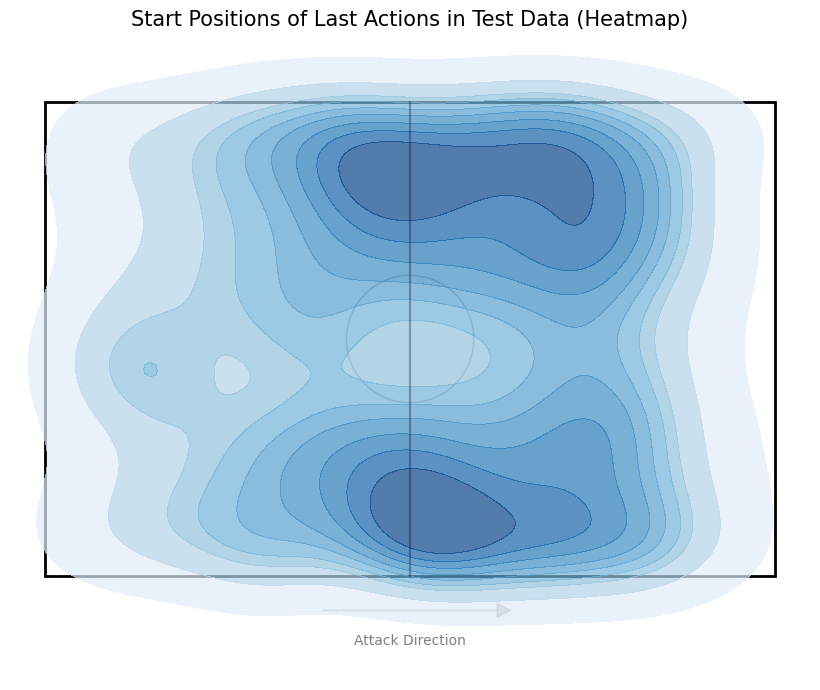


=== Summary Statistics ===
           start_x      start_y
count  2414.000000  2414.000000
mean     54.097560    33.961794
std      25.475036    21.389464
min       0.000000     0.000000
25%      34.793325    14.240849
50%      55.419158    34.381786
75%      75.179790    53.598960
max     104.666205    68.000000

=== Top Action Types ===
type_name
Pass    2414
Name: count, dtype: int64


In [2]:
# 1. 설정: 테스트 데이터 루트 경로
# 예: ./open_track1/test/153363/153363_1.csv 형태라고 가정
TEST_DATA_ROOT = './open_track1/test'

# 2. 데이터 수집 함수
def collect_last_action_starts(root_dir):
    # 하위 폴더 포함 모든 .csv 파일 찾기
    csv_files = glob.glob(os.path.join(root_dir, '*', '*.csv'))
    print(f"총 {len(csv_files)}개의 테스트 에피소드 파일을 찾았습니다.")
    
    data_list = []
    
    for file_path in tqdm(csv_files, desc="데이터 수집 중"):
        try:
            df = pd.read_csv(file_path)
            if df.empty: continue
            
            # 시간 순 정렬 (혹시 섞여 있을 경우 대비)
            df = df.sort_values('time_seconds')
            
            # 마지막 Action의 시작 위치 추출
            last_row = df.iloc[-1]
            data_list.append({
                'game_episode': last_row['game_episode'], # 식별자
                'start_x': last_row['start_x'],
                'start_y': last_row['start_y'],
                'type_name': last_row['type_name']
            })
            
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            continue
            
    return pd.DataFrame(data_list)

# 3. 경기장 그리기 함수
def draw_pitch(ax):
    ax.add_patch(Rectangle((0, 0), 105, 68, fill=False, edgecolor='black', linewidth=2))
    ax.plot([52.5, 52.5], [0, 68], color='black', alpha=0.3, linestyle='-', linewidth=1.5)
    ax.add_patch(Circle((52.5, 34), 9.15, fill=False, edgecolor='black', alpha=0.3))
    
    # 공격 방향 (왼쪽 -> 오른쪽)
    ax.arrow(40, -5, 25, 0, head_width=2, head_length=2, fc='gray', ec='gray', alpha=0.5)
    ax.text(52.5, -10, "Attack Direction", ha='center', fontsize=10, color='gray')
    
    ax.set_xlim(-5, 110)
    ax.set_ylim(-15, 75)
    ax.set_aspect('equal')
    ax.axis('off')

# --- [메인 실행] ---

# (1) 데이터 로드
if os.path.exists(TEST_DATA_ROOT):
    last_actions_df = collect_last_action_starts(TEST_DATA_ROOT)
    
    if not last_actions_df.empty:
        # (2) 시각화: 2D KDE Plot (Heatmap)
        plt.figure(figsize=(10, 7))
        ax = plt.gca()
        
        draw_pitch(ax)
        
        # 데이터가 너무 적으면 산점도(Scatter)로, 충분하면 히트맵(KDE)으로 그리기
        if len(last_actions_df) > 50:
            sns.kdeplot(
                x=last_actions_df['start_x'], 
                y=last_actions_df['start_y'], 
                fill=True, 
                cmap='Blues', 
                thresh=0.05, 
                alpha=0.7, 
                ax=ax
            )
            plt.title("Start Positions of Last Actions in Test Data (Heatmap)", fontsize=15, pad=20)
        else:
            sns.scatterplot(
                x=last_actions_df['start_x'], 
                y=last_actions_df['start_y'], 
                color='blue', 
                alpha=0.6, 
                ax=ax
            )
            plt.title("Start Positions of Last Actions in Test Data (Scatter)", fontsize=15, pad=20)
            
        plt.tight_layout()
        plt.show()
        
        # (3) 통계 출력
        print("\n=== Summary Statistics ===")
        print(last_actions_df[['start_x', 'start_y']].describe())
        print("\n=== Top Action Types ===")
        print(last_actions_df['type_name'].value_counts().head())
        
    else:
        print("데이터를 찾을 수 없습니다.")
else:
    print(f"경로를 찾을 수 없습니다: {TEST_DATA_ROOT}")